CIFAR-10のデータの内容についての理解

In [0]:
# 畳み込みニューラルネットワークを利用した画像認識
# K04-6_CIFAR-10の画像分類

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

[K04-6 課題　2019年4月13日出題]

CNNを使った一般画像認識プログラムを作成する

1.   CIFAR-10データセットを使い、画像を入力して、認識結果を出力するプログラムを作成する
2.   KerasおよびCNNを利用する
3.   モデルの構造やハイパーパラメータを調整して、できる限り高い認識精度を達成する


[参考]
*   Advanced Convolutional Neural Networks [リンク](https://www.tensorflow.org/tutorials/images/deep_cnn)



In [0]:
# CIFAR-10データの読み込み
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


keras.layers.convolutional.Conv2D(filters, kernel_size, strides=1, padding="same")
strides:フィルターの移動幅
padding="same" : 画像の周りをゼロで埋めて、入力画像と同じ画像を出力する。記載なし、もしくはvalidだと出力画像のサイズは小さくなる

CIFAR-10
10種類のいずれかが写っている写真を集めて、ラベルをつけたデータセット

■クラスのラベル（10種類）
airplane（飛行機）
automobile（自動車）
bird（鳥）
cat（猫）
deer（鹿）
dog（犬）
frog（カエル）
horse（馬）
ship（船）
truck（トラック）
クラスラベルは排他式
PythonのcPython 形式で提供される
※BMPやPNGといった画像ファイルではない
　ピクセルデータ配列としてPythonから簡単にう読み込める形式で提供されている
  ピクセルデータしか提供されていないので人の目に見える画像として表示するには一手間かかる

■データ数
6万枚の画像
  8千万枚データ画像のサブセット
  5万枚（各クラス5000枚x10クラス）の訓練画像と10000枚(各クラス1000枚x10クラス)のテスト画像
Alex Krizhevsky氏が整備
    SuperVision(AlexNet)と呼ばれる畳み込みニューラルネットワークを使ってILSVR2012で優勝

32ピクセル x 32ピクセル x RGBの3チャンネルのカラー画像

In [0]:
# ダウンロードしたデータの形を確認する
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (50000, 32, 32, 3)
X_test (10000, 32, 32, 3)
y_train (50000, 1)
y_test (10000, 1)


In [0]:
print("X_train.shape[0]", X_train.shape[0])
print("X_test.shape[0]", X_test.shape[0])

X_train.shape[0] 50000
X_test.shape[0] 10000


In [0]:
# データの形を確認する
print("X_train[0].shape",X_train[0].shape) #32x32x3(3チャンネル：RGB)
print(X_train[0])

print("X_test[0].shape",X_test[0].shape) #32x32x3(3チャンネル：RGB)
print(X_test[0])

X_train[0].shape (32, 32, 3)
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
X_test[0].shape (32, 32, 3)
[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 

In [0]:
# データの形を確認する(教師データ)
print("y_train[0].shape",y_train[0].shape) #32x32x3(3チャンネル：RGB)
print()
print(y_train[0])    # データとしては、ワンホットベクトルにはなっていない

y_train[0].shape (1,)

[6]


In [0]:
# 入力画像を変換
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)    # Keras入力形式に変換 
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32') / 255     # 各画素を0から1に正規化
X_test = X_test.astype('float32') /255

# 出力形式をワンホット表現に変換 (6 ⇒ [0,0,0,0,0,0,7,0,0,0] )
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

print('X_train shape:', X_train.shape)      # X_trainの配列形状
print('Y_train shape:', Y_train.shape)      # Y_trainの配列形状
print(X_train.shape[0], 'train samples')    # 訓練サンプル数
print(X_test.shape[0], 'test samples')      # 評価サンプル数

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
50000 train samples
10000 test samples


[0] airplane (飛行機)
[1] automobile (自動車)
[2] bird (鳥)
[3] cat (猫)
[4] deer (鹿)
[5] dog (犬)
[6] frog (カエル)
[7] horse (馬)
[8] ship (船)
[9] truck (トラック)

[4]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


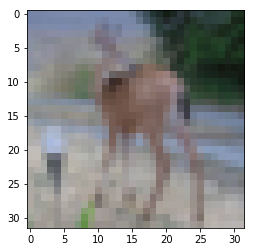

In [0]:
# X_testの100番目の画像を表示
# plt.imshow(X_test[100].reshape([32, 32, 3]))    # 入力画像の例を表示 -> deer(鹿)
plt.imshow(X_test[100])
print(y_test[100])     # 正解データ (ラベル)
print(Y_test[100])     # 正解データ (確率の配列)

In [0]:
# CIFAR10のラベルのnumpyアレイを作成
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])
print(cifar10_labels)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


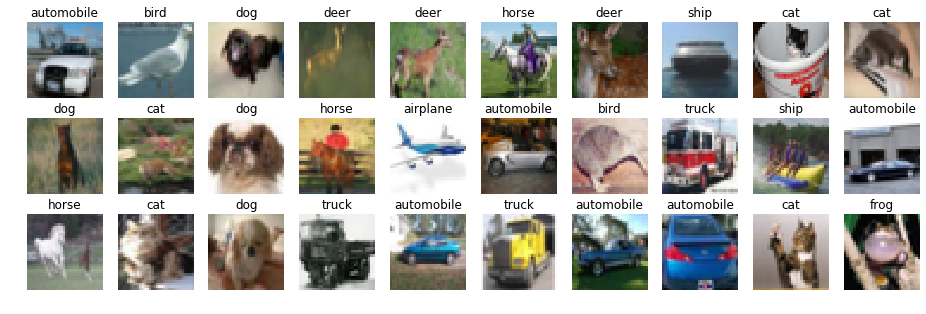

In [0]:
# テスト用サンプルをランダムに表示
import random

# 表示する位置
position = 1    # 初期値(左端上)
index = random.randint(0, X_test.shape[0]/2)    #X_test.shape[0]:32/2 0〜16までのランダムな数字
i = index

# plt figure sizeの設定
plt.figure(figsize=(16,5))

# draw cifar10 images and label names
for img in X_test[index:index+30]:    #index(0〜16までの乱数)
    plt.subplot(3, 10, position)    # 3x10のpos番目
    plt.imshow(img)
    plt.axis('off')
    plt.title(cifar10_labels[y_test[i][0]] )
    position += 1
    i += 1

plt.show()